In [33]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.integrate import odeint
import pandas as pd

In [34]:
# r values 
r_prey_low = 1 #micrometer
r_prey_high = 7 #micrometer
r_pred = 11 #nanometer

In [35]:
# carbon quota for virus
Q_v = ((41*((r_pred - 2.5)**3)+130*(7.5*(r_pred**2)-18.75*r_pred+15.63))*1000000)/(6.022*10**23)
print(Q_v)

1.9656845732314846e-13


In [36]:
#low and high carbon quota for host
Q_h_high = 10**((-0.538+0.158)+((0.86+0.06)*math.log(((4/3)*3.14*(r_prey_high**3)),10)))/(1000000*12.0107)
Q_h_low = 10**((-0.538-0.158)+((0.86-0.06)*math.log(((4/3)*3.14*(r_prey_low**3)),10)))/(1000000*12.0107)
print(Q_h_high,Q_h_low)

2.786257079226697e-05 5.271405050443314e-08


In [37]:
mu = 0.978 # prey growth rate (host growth) 

mu_con =  0.528

lam = 0.704 # rate of predator consumption/interception of prey 
            # (lysis rate) rate of production of predators when they have captured prey

phi = 0.0000000382 # ability of predator to find, recognize, and 
                    # intercept prey (adsorption & initial replication; 
                    # transfer affinity, & clearance rate)
                    #encounter and capture 

beta = 257.54 # amount of predator mass product as a result of 
                # consumption (typically in units of virus particles 
                # produced by lysis of host population) (not a rate) -burst size

#eps =  # amount of resource (prey debris) not consumed by predator- efficiency
 
delta_v = 0.002 # predator death rate (viral decay)
delta_z = 0.002

#different units
    #mu = day^-1
    #lam = day^-1
    #phi = mL of predator^-1 day^-1
    #beta = viruses host^-1
    #eps = fmolC predator^-1
    #delta = day^-1

In [38]:
#quota conversion from carbon to nitrogen (micromol N cell^-1)
Q_h_high = (Q_h_high/6)
Q_v = (Q_v/6)
Q_h_low = (Q_h_low/6)
print(Q_h_high,Q_v)
print(Q_h_high, Q_h_low)


#conversion of parameters
eps = ((beta*Q_v)/(Q_h_low))
phi = (phi/Q_v)

print(eps, phi)

4.643761798711161e-06 3.2761409553858077e-14
4.643761798711161e-06 8.78567508407219e-09
0.0009603557308643218 1166005.9966956293


In [39]:
# time  step
dt = 0.04

# time change (discrete time)
T = 205 / 24.0
t = np.linspace(0, T, 20000)
#t = np.linspace(0,T,int(T/dt))
#print(t)

# array  to store  the  solution
S = np.zeros(len(t))
I = np.zeros(len(t))
V = np.zeros(len(t))
Z = np.zeros(len(t))


# define  initial  conditions... convert using carbon/nitrogen quota
S[0] = 43863.168483*Q_h_low
I[0] = 0.0
V[0] = 1.737401e+06*Q_v
Z[0] = V[0]

y0 = S[0], I[0], V[0], Z[0]
print(y0)

print(phi*V[0])

(0.00038536754644955364, 0.0, 5.691970572028258e-08, 5.691970572028258e-08)
0.0663687182


In [40]:
# new parameters


gmax = 5 #day^-1

k_g = 0.005 # micromol N L^-1

k_g = k_g*(1/1000) # conversion to micromol N to mL

eps_z = 0.2

In [41]:
# differential equations 

#dSdt = mu*S - phi*S*V - g_S*Z
#dIdt = phi*S*V - lam*I -g_I*Z
#dVdt = eps*lam*I - delta_v*V
#dZdt = eps_z*f*Z - delta_z*Z

def sivz_model(y, t, mu, lam, phi, delta_v, delta_z, eps, eps_z, k_g,gmax):
    S,I,V,Z = y[0],y[1],y[2],y[3]
    f = ((S+I)/((S+I)+k_g))*gmax
    g_I = (I/((S+I)))*f
    g_S = (S/((S+I)))*f
    dSdt = mu*S - phi*S*V - g_S*Z
    #print(mu,phi*V,g_S)
    dIdt = phi*S*V - lam*I -g_I*Z
    dVdt = eps*lam*I - delta_v*V
    dZdt = eps_z*f*Z - delta_z*Z
    #print(eps_z*f,delta_z,Z)
    return dSdt, dIdt, dVdt, dZdt



integ_sivz = odeint(sivz_model, y0, t, args=(mu, lam, phi, delta_v, delta_z, eps, eps_z, k_g,gmax))

In [42]:
print(integ_sivz)


[[ 3.85367546e-04  0.00000000e+00  5.69197057e-08  5.69197057e-08]
 [ 3.85517503e-04  1.09242559e-08  5.69196587e-08  5.69436615e-08]
 [ 3.85667518e-04  2.18494664e-08  5.69196148e-08  5.69676275e-08]
 ...
 [ 2.46103709e-19 -2.02867026e-12  1.11805029e-05  2.13312197e-04]
 [ 2.45297310e-19 -2.02203585e-12  1.11804934e-05  2.13312015e-04]
 [ 2.44490910e-19 -2.01540143e-12  1.11804838e-05  2.13311833e-04]]


0     0.000369
1     0.000700
2     0.001168
3     0.002033
4     0.003391
5     0.005086
6     0.007158
7     0.009251
8     0.012234
9     0.015833
10    0.014900
11    0.016266
12    0.018949
Name: abundance, dtype: float64


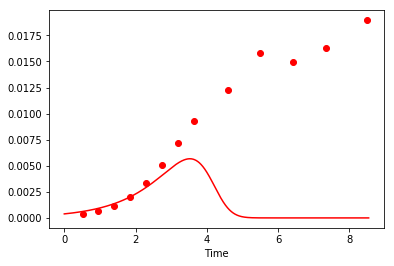

In [43]:
#steady states
plt.plot(t,integ_sivz[:,0],'r')



#plt.plot(t,S, 'r--')
plt.xlabel('Time', color = 'k')


dS_csv = pd.read_csv('Tomaru_43_fig6a_host_control.txt',delimiter=',')
#print(dS_csv)
unlogS = (10**(dS_csv['abundance']))*Q_h_low
print(unlogS)

dS_csv["time"] = dS_csv["time"]/24.0
plt.plot(dS_csv['time'],unlogS,'or')


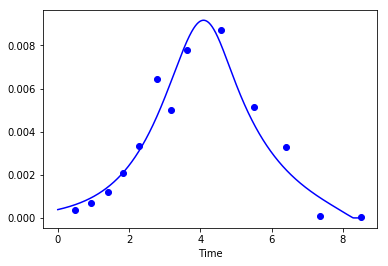

In [44]:
plt.plot(t,integ_sivz[:,1]+integ_sivz[:,0],'b')


#plt.plot(t,I, 'b')
plt.xlabel('Time', color = 'k')

dI_csv = pd.read_csv('Tomaru_43_fig6a_host_infected.txt',delimiter=',')
#print(dI_csv)


unlogI = (10**(dI_csv['abundance']))*Q_h_low
#print(unlogI)

dI_csv["time"] = dI_csv["time"]/24.0

plt.plot(dI_csv['time'],unlogI,'ob')
#plt.plot(t,S+I,'b')


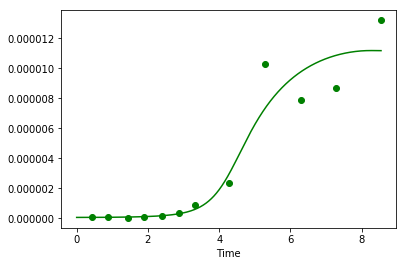

In [45]:
plt.plot(t,integ_sivz[:,2],'g')


#plt.plot(t,V, 'g')
plt.xlabel('Time', color = 'k')



dV_csv = pd.read_csv('Tomaru_43_fig6b_viral_abundance.txt',delimiter=',')
#print(dV_csv)

unlogV = (10**(dV_csv['virus']))*Q_v
#print(unlogV)

dV_csv["time"] = dV_csv["time"]/24.0

plt.plot(dV_csv['time'],unlogV,'og')
#plt.plot(t,V,'g')

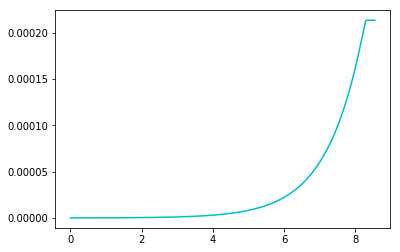

In [46]:
plt.plot(t,integ_sivz[:,3],'c')

[]

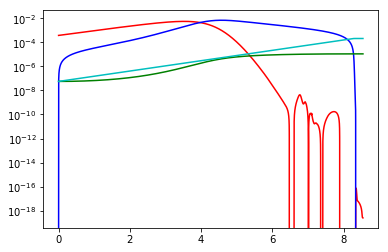

In [47]:
plt.plot(t,integ_sivz[:,0],'r') # host
plt.plot(t,integ_sivz[:,1],'b') # infected
plt.plot(t,integ_sivz[:,2],'g') # virus
plt.plot(t,integ_sivz[:,3],'c') # grazer

plt.semilogy()

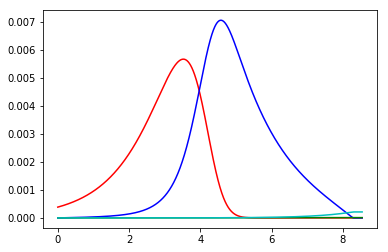

In [48]:
plt.plot(t,integ_sivz[:,0],'r') # host
plt.plot(t,integ_sivz[:,1],'b') # infected
plt.plot(t,integ_sivz[:,2],'g') # virus
plt.plot(t,integ_sivz[:,3],'c') # grazer